<a href="https://colab.research.google.com/github/vknalluri/MyProjects/blob/master/transformers2_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transformers for Sentiment Classification

Welcome folks!, in the current project I will show you in detail how to implement four types of well-known transformer models making use of the transformers HuggingFace library and Keras API. 

The main task corresponds to a multi-class text classification on Movie Reviews Competition and the dataset contains 156.060 instances for training, whereas the testing set contains 66.292 from which we have to classify among 5 classes. The sentiment labels are:

- 0 → Negative
- 1 → Somewhat negative
- 2 → Neutral
- 3 → Somewhat positive
- 4 → Positive

At the end of the project we will summarize and compare their performance according to our requirements and metrics. 



In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
sns.set(style='whitegrid')

from wordcloud import WordCloud

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.metrics import classification_report,confusion_matrix

from collections import defaultdict
from collections import Counter

import re
import gensim
import string

from tqdm import tqdm
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM,Dense, SpatialDropout1D, Dropout
from keras.initializers import Constant

import tensorflow as tf
import warnings
warnings.simplefilter('ignore')

Let's start by unzipping and reading the 3 tsv files containing training, testing and sample submission:

In [2]:
df=pd.read_csv('train.tsv', sep='\t')
df_test=pd.read_csv('test.tsv', sep='\t')
#sample_submission=pd.read_csv('../input/sentiment-analysis-on-movie-reviews/sampleSubmission.csv')

Just to confirm the number of instances and features in each file:

In [3]:
df.shape, df_test.shape

((156060, 4), (66292, 3))

In [4]:
df

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2
...,...,...,...,...
156055,156056,8544,Hearst 's,2
156056,156057,8544,forced avuncular chortles,1
156057,156058,8544,avuncular chortles,3
156058,156059,8544,avuncular,2


Above we can see that Phrase and Sentiment columns are all we need from the file in order to train the models later, therefore we will use these as feature (X) and label (Y) when fitting the transformer.

In [5]:
df_test

,PhraseId,SentenceId,Phrase
0,156061,8545,An intermittently pleasing but mostly routine ...
1,156062,8545,An intermittently pleasing but mostly routine ...
2,156063,8545,An
3,156064,8545,intermittently pleasing but mostly routine effort
4,156065,8545,intermittently pleasing but mostly routine
...,...,...,...
66287,222348,11855,"A long-winded , predictable scenario ."
66288,222349,11855,"A long-winded , predictable scenario"
66289,222350,11855,"A long-winded ,"
66290,222351,11855,A long-winded


In case there is a null or empty value in any column we should have to get rid of it, in order to find it out we will use info() as follows:

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156060 entries, 0 to 156059
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   PhraseId    156060 non-null  int64 
 1   SentenceId  156060 non-null  int64 
 2   Phrase      156060 non-null  object
 3   Sentiment   156060 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 4.8+ MB


In [7]:
df.isnull().sum()

PhraseId      0
SentenceId    0
Phrase        0
Sentiment     0
dtype: int64

The dataset looks good and we need to know how are distributed the 5 classes in the label so as to know it's balanced or not.


In [8]:
df.Sentiment.value_counts()

2    79582
3    32927
1    27273
4     9206
0     7072
Name: Sentiment, dtype: int64

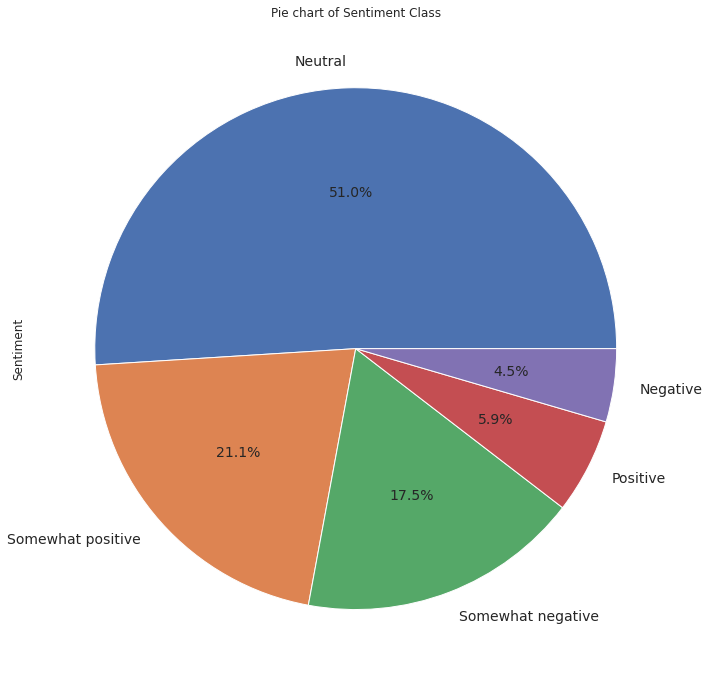

In [9]:
df2=df.copy(deep=True)
pie1=pd.DataFrame(df2['Sentiment'].replace(0,'Negative').replace(1,'Somewhat negative').replace(2,'Neutral').replace(3,'Somewhat positive').replace(4,'Positive').value_counts())
pie1.reset_index(inplace=True)
pie1.plot(kind='pie', title='Pie chart of Sentiment Class',y = 'Sentiment', 
          autopct='%1.1f%%', shadow=False, labels=pie1['index'], legend = False, fontsize=14, figsize=(12,12))

The label is considerably unbalanced, only 'Neutral' corresponds to more than 50% of instances and there is a slightly skewed towards positive reviews. Early we can say the class to be predicted will be sidetracked toward the more frequent classes, this is why we need a text balancing technique just like 'SMOTE' for numerical features.

Time now to find out the number of words in reviews, in order to understand a bit better we will plot histograms for each class 

Text(0.5, 0.98, 'Histogram number of words in reviews')

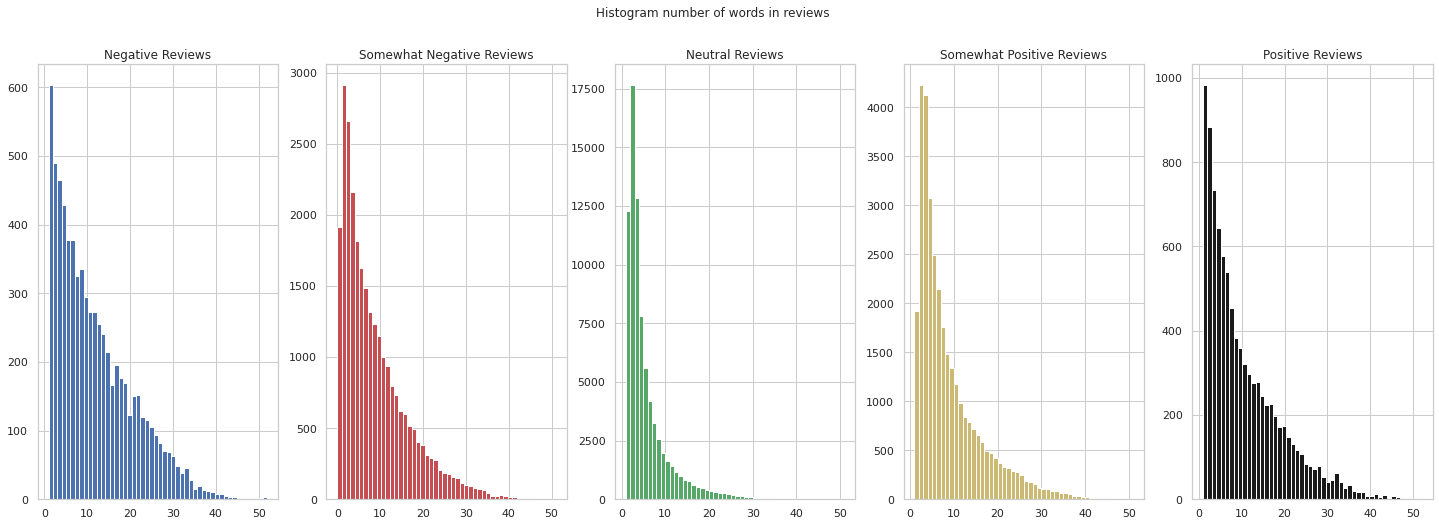

In [10]:
f, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1,5,figsize=(25,8))

ax1.hist(df[df['Sentiment'] == 0]['Phrase'].str.split().map(lambda x: len(x)), bins=50, color='b')
ax1.set_title('Negative Reviews')

ax2.hist(df[df['Sentiment'] == 1]['Phrase'].str.split().map(lambda x: len(x)), bins=50, color='r')
ax2.set_title('Somewhat Negative Reviews')

ax3.hist(df[df['Sentiment'] == 2]['Phrase'].str.split().map(lambda x: len(x)), bins=50, color='g')
ax3.set_title('Neutral Reviews')

ax4.hist(df[df['Sentiment'] == 3]['Phrase'].str.split().map(lambda x: len(x)), bins=50, color='y')
ax4.set_title('Somewhat Positive Reviews')

ax5.hist(df[df['Sentiment'] == 4]['Phrase'].str.split().map(lambda x: len(x)), bins=50, color='k')
ax5.set_title('Positive Reviews')

f.suptitle('Histogram number of words in reviews')

In the 5 histograms we can see the distribution behaves like a negative exponential function decreasing significatively as the x-axis increases. It seems like the longest sentence in Phrase column corresponds to a class 'Negative Reviews' and is around 52 words, now let's  obtain the longest one by using the max() function: 

In [11]:
df['Phrase'].str.split().map(lambda x: len(x)).max()

52

Effectively was 52 words, this means if we would Tokenize by word the max_length should be 52, however as transformers consider sub-words tokenization such number could be increased depending on the words being used which can increase such length to 60 or even more, thus we have to take that into account when modeling as it could cause our model to take significatively a long time to train, therefore we have to find a trade-off between training time and performance.

In [12]:
dfff=pd.DataFrame(df['Phrase'].str.split().map(lambda x: len(x))>=20)
print('Number of sentences which contain more than 20 words: ', dfff.loc[dfff['Phrase']==True].shape[0])
print(' ')
dfff=pd.DataFrame(df['Phrase'].str.split().map(lambda x: len(x))>=30)
print('Number of sentences which contain more than 30 words: ', dfff.loc[dfff['Phrase']==True].shape[0])
print(' ')
dfff=pd.DataFrame(df['Phrase'].str.split().map(lambda x: len(x))>=40)
print('Number of sentences which contain more than 40 words: ', dfff.loc[dfff['Phrase']==True].shape[0])
print(' ')
dfff=pd.DataFrame(df['Phrase'].str.split().map(lambda x: len(x))>=50)
print('Number of sentences which contain more than 50 words: ', dfff.loc[dfff['Phrase']==True].shape[0])
print(' ')
dfff=pd.DataFrame(df['Phrase'].str.split().map(lambda x: len(x))==52)
print('Number of sentences which contain 52 words: ', dfff.loc[dfff['Phrase']==True].shape[0])
print(' ')
#dfff.loc[dfff['Phrase']==True]

Number of sentences which contain more than 20 words:  11494
 
Number of sentences which contain more than 30 words:  2568
 
Number of sentences which contain more than 40 words:  352
 
Number of sentences which contain more than 50 words:  18
 
Number of sentences which contain 52 words:  3
 


Above we see 352 reviews contain more than 40 words and only 18 reviews above 50 words, these two number corresponds to a tiny proportion of the total number of instances (156.060), therefore setting to these numbers will not affect too much the classification. Below we can see an example of a sentence containing 52 words, observe there are misspelled words, acronyms and some of them can be decomposed into sub-words:

In [13]:
print(df.loc[87835,'Phrase'])

There are n't too many films that can be as simultaneously funny , offbeat and heartwarming -LRB- without a thick shmear of the goo , at least -RRB- , but `` Elling '' manages to do all three quite well , making it one of the year 's most enjoyable releases .


# Modeling

In this step we will build, train and compare the following algorithms:

- BERT (Bidirectional Encoder Representation from Transformers)
- RoBERTa (Robustly Optimized BERT Pre-training Approach)
- DistilBERT (Distilled BERT)
- XLNet (Generalized Auto-Regressive model)

Each one of the mentioned have its pros and cons, the most preferred and widely used model is the BERT for being the middle term in performance, whereas RoBERTa and .. are known for their better error metrics and DistilBERT for its faster training. We will consider all of these chracteristics and choose the best one for our dataset.

Firstly, we have to install the transformers library offered by HuggingFace so as enable all useful functions when building the four models.

In [14]:
!pip install --upgrade transformers

     |████████████████████████████████| 4.0 MB 5.3 MB/s 
     |████████████████████████████████| 880 kB 75.1 MB/s 
     |████████████████████████████████| 596 kB 69.5 MB/s 
     |████████████████████████████████| 77 kB 7.0 MB/s 
     |████████████████████████████████| 6.6 MB 74.7 MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895260 sha256=d84cbe980b2db36bdc78596b7a0d90c08a6b2822685da3ccfbd69a84d9318479
  Stored in directory: /root/.cache/pip/wheels/87/39/dd/a83eeef36d0bf98e7a4d1933a4ad2d660295a40613079bafc9
Successfully built sacremoses
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


Then what we need from tensorflow.keras:

In [15]:
from tensorflow.keras.layers import Input, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.utils import to_categorical

import pandas as pd
from sklearn.model_selection import train_test_split

Now we have to gather from the dataset only the two columns useful for training (Phrase and Sentiment):

In [16]:
data = df[['Phrase', 'Sentiment']]

# Set your model output as categorical and save in new label col
data['Sentiment_label'] = pd.Categorical(data['Sentiment'])

# Transform your output to numeric
data['Sentiment'] = data['Sentiment_label'].cat.codes

Split into train and validation set, as the file contains more than 150 thousand instances we can consider only a small portion of it as validation and still the number is relatively long, because of this we will set the test_size to 10% as follows:

In [17]:
data_train, data_val = train_test_split(data, test_size = 0.1)

# Bert

As first step we have to import the Model, Config and Tokenizer corresponding to Bert in order to build properly the model. 

In [18]:
from transformers import TFBertModel,  BertConfig, BertTokenizerFast

The model we will use is 'bert_base_uncased' and the max_length chosen is 45 as there are only a very small number of larger sequences.

In [19]:
# Name of the BERT model to use
model_name = 'bert-base-uncased'

# Max length of tokens
max_length = 45

# Load transformers config and set output_hidden_states to False
config = BertConfig.from_pretrained(model_name)
config.output_hidden_states = False

# Load BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained(pretrained_model_name_or_path = model_name, config = config)

# Load the Transformers BERT model
transformer_bert_model = TFBertModel.from_pretrained(model_name, config = config)

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/511M [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Now that our model has been loaded we can start the processes of building and tuning according to our dataset and task using the functional API of keras.

As we see below the input layer must consider the max_length of sequences and then this is fed to the bert model, a dropout layer to reduce overfitting (0.1) and finally a dense layer with number of neurons equal to number of classes in our label (5).

In [20]:
### ------- Build the model ------- ###

# Load the MainLayer
bert = transformer_bert_model.layers[0]

# Build your model input
input_ids = Input(shape=(max_length,), name='input_ids', dtype='int32')
inputs = {'input_ids': input_ids}

# Load the Transformers BERT model as a layer in a Keras model
bert_model = bert(inputs)[1]
dropout = Dropout(config.hidden_dropout_prob, name='pooled_output')
pooled_output = dropout(bert_model, training=False)

# Then build your model output
Sentiments = Dense(units=len(data_train.Sentiment_label.value_counts()), kernel_initializer=TruncatedNormal(stddev=config.initializer_range), name='Sentiment')(pooled_output)
outputs = {'Sentiment': Sentiments}

# And combine it all in a model object
model = Model(inputs=inputs, outputs=outputs, name='BERT_MultiClass')

# Take a look at the model
model.summary()

Model: "BERT_MultiClass"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_ids (InputLayer)      [(None, 45)]              0         
                                                                 
 bert (TFBertMainLayer)      TFBaseModelOutputWithPoo  109482240 
                             lingAndCrossAttentions(l            
                             ast_hidden_state=(None,             
                             45, 768),                           
                              pooler_output=(None, 76            
                             8),                                 
                              past_key_values=None, h            
                             idden_states=None, atten            
                             tions=None, cross_attent            
                             ions=None)                          
                                                   

The next cell considers the tokenization of training and validation sentences, setting of label as categorical and finally model training.

In [21]:
### ------- Train the model ------- ###

# Set an optimizer
optimizer = Adam(learning_rate=5e-05,epsilon=1e-08,decay=0.01,clipnorm=1.0)

# Set loss and metrics
loss = {'Sentiment': CategoricalCrossentropy(from_logits = True)}

# Compile the model
model.compile(optimizer = optimizer, loss = loss, metrics = ['accuracy'])

# Ready output data for the model
y_train = to_categorical(data_train['Sentiment'])

# Tokenize the input (takes some time)
x_train = tokenizer(
          text=data_train['Phrase'].to_list(),
          add_special_tokens=True,
          max_length=max_length,
          truncation=True,
          padding=True, 
          return_tensors='tf',
          return_token_type_ids = False,
          return_attention_mask = True,
          verbose = True)

y_val = to_categorical(data_val['Sentiment'])

x_val = tokenizer(
          text=data_val['Phrase'].to_list(),
          add_special_tokens=True,
          max_length=max_length,
          truncation=True,
          padding=True, 
          return_tensors='tf',
          return_token_type_ids = False,
          return_attention_mask = True,
          verbose = True)

# Fit the model
history = model.fit(
    x={'input_ids': x_train['input_ids']},
    y={'Sentiment': y_train},
    validation_data=({'input_ids': x_val['input_ids']},{'Sentiment': y_val}),
    batch_size=64,
    epochs=2,
    verbose=1)

Epoch 1/2
2195/2195 [==============================] - 6811s 3s/step - loss: 0.8035 - accuracy: 0.6666 - val_loss: 0.7554 - val_accuracy: 0.6826
Epoch 2/2
2195/2195 [==============================] - 6573s 3s/step - loss: 0.7081 - accuracy: 0.7069 - val_loss: 0.7385 - val_accuracy: 0.6916


The model took 27 minutes and 20 seconds to train for 2 epochs.

## Evaluate on validation set:

We will compute the error metrics on the validation set in order to have an idea of the model performance.

In [22]:
model_eval = model.evaluate(
    x={'input_ids': x_val['input_ids']},
    y={'Sentiment': y_val}
)

488/488 [==============================] - 302s 619ms/step - loss: 0.7385 - accuracy: 0.6916


In [23]:
y_val_predicted = model.predict(
    x={'input_ids': x_val['input_ids']},
)

y_val_predicted corresponds to a numpy array representing the instances and the prediction as one-hot encoded, the actual label is formatted in the same manner, let's them see in detail:

In [24]:
y_val_predicted['Sentiment']

array([[-3.7198782 , -1.695698  ,  2.5250015 ,  2.9341633 , -0.43891746],
       [-3.1544085 , -0.45828354,  4.5009456 ,  1.347527  , -2.490345  ],
       [-2.7583578 , -2.6113045 , -0.2027465 ,  2.8010125 ,  2.712204  ],
       ...,
       [-3.6432552 , -0.73009276,  2.8734205 ,  2.5730793 , -1.3927963 ],
       [-3.212163  , -0.29313385,  4.4478536 ,  1.358183  , -2.7082644 ],
       [-3.756278  , -1.769789  ,  1.893703  ,  2.944277  ,  0.24745458]],
      dtype=float32)

In [25]:
y_val

array([[0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.]], dtype=float32)

In order to compute the classification report and confusion matrix we will convert the matrices to one column representing the argmax for each row:

In [26]:
y_val_pred_max=[np.argmax(i) for i in y_val_predicted['Sentiment']]

In [27]:
y_val_actual_max=[np.argmax(i) for i in y_val]

In [28]:
from sklearn.metrics import classification_report

report = classification_report(y_val_pred_max, y_val_actual_max)

print(report)

              precision    recall  f1-score   support

           0       0.46      0.54      0.50       635
           1       0.61      0.57      0.59      2969
           2       0.78      0.79      0.79      7796
           3       0.64      0.62      0.63      3362
           4       0.54      0.56      0.55       844

    accuracy                           0.69     15606
   macro avg       0.61      0.62      0.61     15606
weighted avg       0.69      0.69      0.69     15606



The fact that our dataset is unbalanced in classes makes our prediction absolutely sidetracked towards the most frequent class, in this case (2: 'Neutral'), because of this the performance of the model is poor when predicting classes 0 or 4, making our model almost unuseful for this task. Below we can see for these 2 classes the number of misclassifications is huge.

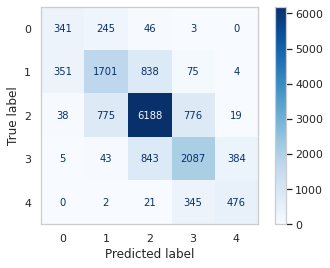

In [29]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_val_pred_max, y_val_actual_max), display_labels=np.unique(y_val_actual_max))
disp.plot(cmap='Blues') 
plt.grid(False)

## Inference:

In this step we will predict the classes corresponding to the test set (out-of-bag) instances, because of the huge dataset we can expect to have almost same performance.

In [30]:
x_test = tokenizer(
          text=df_test['Phrase'].to_list(),
          add_special_tokens=True,
          max_length=max_length,
          truncation=True,
          padding=True, 
          return_tensors='tf',
          return_token_type_ids = False,
          return_attention_mask = False,
          verbose = True)

In [31]:
label_predicted = model.predict(
    x={'input_ids': x_test['input_ids']},
)

In [32]:
label_predicted['Sentiment']

array([[-2.7982092 , -0.23692012,  1.6607695 ,  2.0081136 , -1.0349743 ],
       [-3.0019846 , -0.344447  ,  1.8105384 ,  2.159017  , -1.0507915 ],
       [-3.3570538 , -0.41788015,  4.5320907 ,  1.4609495 , -2.5076838 ],
       ...,
       [-0.212571  ,  2.831898  ,  2.4488802 , -1.0208452 , -3.8680997 ],
       [-0.4126992 ,  2.797435  ,  2.6093464 , -0.94592136, -3.9141998 ],
       [ 0.04566947,  3.112097  ,  2.2162495 , -1.2773408 , -3.931776  ]],
      dtype=float32)

In [33]:
label_pred_max=[np.argmax(i) for i in label_predicted['Sentiment']]

In [34]:
label_pred_max[:10]

[3, 3, 2, 3, 3, 3, 3, 2, 3, 2]